In [1]:
from pathlib import Path
import math
import sys
import yaml
import time
import os
import copy

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import lines
from geopy.geocoders import GoogleV3, Nominatim

DIR = Path('..')
sys.path.insert(0, str(DIR))
from SCanalyzer import SCanalyzer
from SCanalyzer.busSim import BusSim, Config
from SCanalyzer.busSim.manager import managerFactory
from SCanalyzer.gtfs_edit import edit_double
from SCanalyzer.util import findEPSG
from SCanalyzer.busSim.manager import LocalManager
from pyproj import Transformer

import warnings
from shapely.errors import ShapelyDeprecationWarning
from shapely.geometry import Point
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

%matplotlib inline

manger init
mangager register
mangager register


In [2]:
def get_yelp_api_key():
    with open("../config.yml", 'r') as yml:
        cfg = yaml.safe_load(yml)
        return cfg["yelp"]["api_key"]

def plot_background(crs):
    background_path = os.path.join('..', 'data', 'plot', 'background', 'lansing')
    city = gpd.read_file(os.path.join(background_path, "Cities.zip")).to_crs(crs)
    # lakes = gpd.read_file(os.path.join(background_path, "Rivers.zip")).to_crs(crs)
    # street = gpd.read_file(os.path.join(background_path, "Roads.zip")).to_crs(crs)
    # city = gpd.read_file(background_path + "madison-shp")
    # lakes = gpd.read_file(background_path + "water-shp")
    # street = gpd.read_file(background_path + "street-shp")

    ax = city.plot(color="gray", alpha=.5, figsize=(12, 12), zorder=2)
    # ax = city.plot(color="lightgray", alpha=.2, figsize=(12, 12), zorder=2)
    # lakes.plot(color="lightblue", ax=ax, zorder=1, alpha=0.8)
    # street.plot(color="darkgray", alpha = .5, ax=ax, zorder=3)
    return ax

cache = {}
def geocode(addr):
    # if not "madison" in addr.lower():
    #     addr += ", Madison WI"
    if not addr in cache:
        cache[addr] = geolocator.geocode(addr)
    return cache[addr]

def flatten(s):
    return gpd.GeoDataFrame({"geometry": gpd.GeoSeries([s.unary_union])})

def get_score(area, banks=0, clinics=0, dentists=0, hospitals=0, supermarkets=0):
    x6 = 1
    if banks == 0:
        x6 = x6/2
    if supermarkets == 0:
        x6 = x6/2
    if hospitals == 0:
        x6 = x6/2
    if clinics == 0:
        x6 = x6/2
    if dentists == 0:
        x6 = x6/2
    score = (area + banks + clinics + hospitals + dentists + supermarkets) * x6
    return score

In [3]:
DATA_PATH = "../data/lansing_gtfs.zip"
OUT_PATH = "/tmp/output"
DAY = "monday"
START_TIME = "07:00:00"
ELAPSE_TIME = "01:30:00"
AVG_WALKING_SPEED = 1.4 # 1.4 meters per second
MAX_WALKING_MIN = 10

api_key = 'ZsHZFGtKEZeOOXhTne98eErmfd6BfNTm9GqO2S6inSnWzDwtgC2sEauXcB-8zUna_lXZEal4jsW_St6O0OQOcuNvifrr6uqNYmjFXW-FyVKvaMyczbihWELI80tjYHYx'
gtfo = SCanalyzer(DATA_PATH)
census_gdf = gtfo.load_census()
services_gdf = gtfo.load_yelp(api_key=api_key)

stops_meter exists


In [4]:
background_path = os.path.join('..', 'data', 'plot', 'background', 'lansing')
city = gpd.read_file(os.path.join(background_path, "Cities.zip")).to_crs(4326)
# lakes = gpd.read_file(os.path.join(background_path, "Rivers.zip")).to_crs(4326)
# street = gpd.read_file(os.path.join(background_path, "Roads.zip")).to_crs(4326)
max_lon = city.bounds.maxx.max()
min_lon = city.bounds.minx.min()
max_lat = city.bounds.maxy.max()
min_lat = city.bounds.miny.min()

geolocator = Nominatim(user_agent="wisc_bazarr_demo")
manager = LocalManager(DATA_PATH, OUT_PATH, None)
busSim = BusSim(manager, DAY, START_TIME, ELAPSE_TIME, AVG_WALKING_SPEED, MAX_WALKING_MIN)

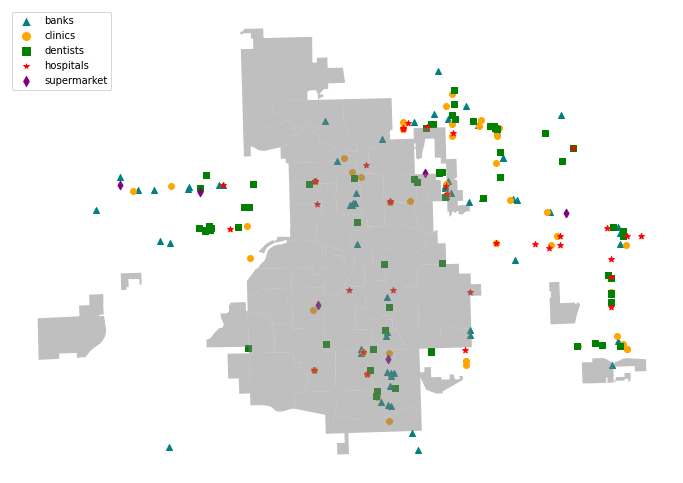

In [5]:
temp_df = services_gdf.apply(copy.deepcopy)

ax = plot_background(f"EPSG:{gtfo.epsg}")

epsg = findEPSG(temp_df['latitude'].iloc[0], temp_df['longitude'].iloc[0])
transformer = Transformer.from_crs(4326, epsg)
stop_x, stop_y = transformer.transform(
            temp_df['latitude'], temp_df['longitude'])
temp_df['stop_x'], temp_df['stop_y'] = stop_x, stop_y
temp_df = temp_df[(temp_df['latitude'] < max_lat) & (temp_df['latitude'] > min_lat) & (temp_df['longitude'] < max_lon) & (temp_df['longitude'] > min_lon)]
banks = temp_df[temp_df['service'] == 'banks']
clinics = temp_df[temp_df['service'] == 'clinics']
dentists = temp_df[temp_df['service'] == 'dentists']
hospitals = temp_df[temp_df['service'] == 'hospitals']
supermarket = temp_df[temp_df['service'] == 'supermarket']
banks = gpd.GeoDataFrame(
    banks['service'], geometry=gpd.points_from_xy(banks.stop_x, banks.stop_y), crs="EPSG:"+str(epsg))
clinics = gpd.GeoDataFrame(
    clinics['service'], geometry=gpd.points_from_xy(clinics.stop_x, clinics.stop_y), crs="EPSG:"+str(epsg))
dentists = gpd.GeoDataFrame(
    dentists['service'], geometry=gpd.points_from_xy(dentists.stop_x, dentists.stop_y), crs="EPSG:"+str(epsg))
hospitals = gpd.GeoDataFrame(
    hospitals['service'], geometry=gpd.points_from_xy(hospitals.stop_x, hospitals.stop_y), crs="EPSG:"+str(epsg))
supermarket = gpd.GeoDataFrame(
    supermarket['service'], geometry=gpd.points_from_xy(supermarket.stop_x, supermarket.stop_y), crs="EPSG:"+str(epsg))
banks.plot(ax=ax, color='teal', marker='^')
clinics.plot(ax=ax, color='orange', marker='o')
dentists.plot(ax=ax, color='green', marker='s')
hospitals.plot(ax=ax, color='red', marker='*')
supermarket.plot(ax=ax, color='purple', marker='d')

lineslist = []
lineslist.append(lines.Line2D([],[],color="white", markerfacecolor = "teal", marker = "^", markersize=10, label = "banks"))
lineslist.append(lines.Line2D([],[],color="white", markerfacecolor = "orange", marker = "o", markersize=10, label = "clinics"))
lineslist.append(lines.Line2D([],[],color="white", markerfacecolor = "green", marker = "s", markersize=10, label = "dentists"))
lineslist.append(lines.Line2D([],[],color="white", markerfacecolor = "red", marker = "*", markersize=10, label = "hospitals"))
lineslist.append(lines.Line2D([],[],color="white", markerfacecolor = "purple", marker = "d", markersize=10, label = "supermarket"))
ax.legend(handles = lineslist, loc="upper left",prop={"size": 10})
# ax.legend(handles = lineslist, bbox_to_anchor=(1.00, 1.00), loc="upper left",prop={"size": 10})

ax.set_axis_off()

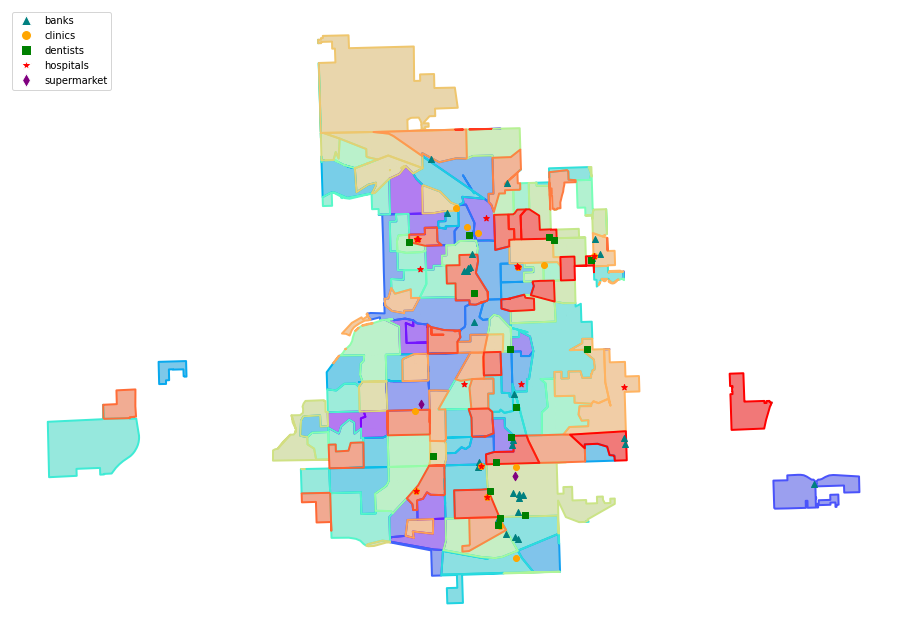

In [6]:
# census boundary

city = city.to_crs(epsg)
# lakes = lakes.to_crs(epsg)
# street = street.to_crs(epsg)
# ax = lakes.boundary.plot(color="lightblue", zorder=1, linewidth=2, figsize=(16, 16))
# lakes.plot(color="lightblue", ax=ax, alpha=0.2, zorder=1)
ax = city.plot(color="black", alpha=0.05, zorder=2, figsize=(16, 16))
# street.plot(color="black", alpha=0.3, ax=ax, zorder=3)

new_census = census_gdf.to_crs(epsg).intersection(city.unary_union)
new_census[~new_census.is_empty].plot(ax=ax, cmap='rainbow', alpha=0.5)
new_census[~new_census.is_empty].boundary.plot(ax=ax, cmap='rainbow', linewidth=2)

banks.intersection(city.unary_union).plot(ax=ax, color='teal', marker='^', zorder=4)
clinics.intersection(city.unary_union).plot(ax=ax, color='orange', marker='o', zorder=4)
dentists.intersection(city.unary_union).plot(ax=ax, color='green', marker='s', zorder=4)
hospitals.intersection(city.unary_union).plot(ax=ax, color='red', marker='*', zorder=4)
supermarket.intersection(city.unary_union).plot(ax=ax, color='purple', marker='d', zorder=4)

ax.legend(handles = lineslist, loc="upper left",prop={"size": 10})
# ax.legend(handles = lineslist, bbox_to_anchor=(1.00, 1.00), loc="upper left",prop={"size": 10})

ax.set_axis_off()


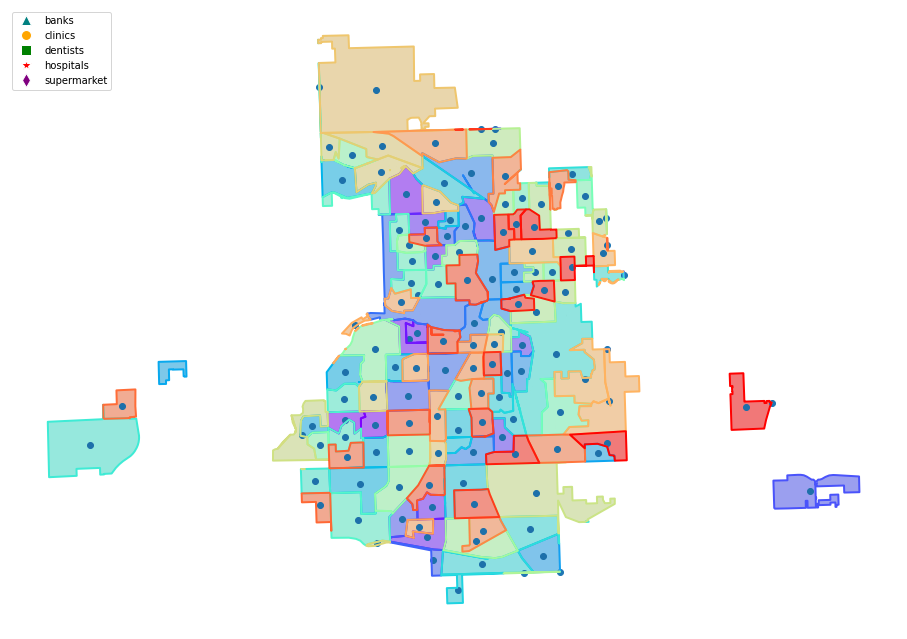

In [7]:
# census centroid

ax = city.plot(color="black", alpha=0.05, zorder=2, figsize=(16, 16))

new_census = census_gdf.to_crs(epsg).intersection(city.unary_union)
new_census[~new_census.is_empty].plot(ax=ax, cmap='rainbow', alpha=0.5)
new_census[~new_census.is_empty].boundary.plot(ax=ax, cmap='rainbow', linewidth=2)
new_census.centroid.intersection(city.unary_union).plot(ax=ax)

ax.legend(handles = lineslist, loc="upper left",prop={"size": 10})
# ax.legend(handles = lineslist, bbox_to_anchor=(1.00, 1.00), loc="upper left",prop={"size": 10})

ax.set_axis_off()

In [22]:
# the number of each building in each census block
new_census = census_gdf.copy(True)
new_census['banks'] = 0
new_census['clinics'] = 0
new_census['dentists'] = 0
new_census['hospitals'] = 0
new_census['supermarket'] = 0
for idx, row in new_census.bounds.iterrows():
    for _, service in services_gdf.iterrows():
        if row['miny'] <= service['latitude'] <= row['maxy'] and row['minx'] <= service['longitude'] <= row['maxx']:
            new_census.loc[idx, service['service']] += 1

In [23]:
new_census

,STATE,COUNTY,TRACT,BLKGRP,geometry,NAME,B02001_001E,B02001_002E,B02001_003E,B02001_004E,...,% Black or African American alone,% American Indian and Alaska Native alone,% Asian alone alone,% Native Hawaiian and Other Pacific Islander alone,cars per capita,banks,clinics,dentists,hospitals,supermarket
0,26,45,21002,4,"POLYGON ((-84.79773 42.55289, -84.79760 42.523...","Block Group 4, Census Tract 210.02, Eaton Coun...",1773,1761,12,0,...,0.006768,0.000000,0.000000,0.0,0.396503,0,0,0,0,0
1,26,45,20304,1,"POLYGON ((-84.66909 42.76991, -84.66807 42.762...","Block Group 1, Census Tract 203.04, Eaton Coun...",1470,1294,176,0,...,0.119728,0.000000,0.000000,0.0,0.477551,1,0,0,0,1
2,26,45,21302,2,"POLYGON ((-84.66912 42.50639, -84.66914 42.505...","Block Group 2, Census Tract 213.02, Eaton Coun...",1322,1278,8,0,...,0.006051,0.000000,0.006051,0.0,0.409985,1,1,1,0,1
3,26,45,21202,2,"POLYGON ((-84.65978 42.48308, -84.65953 42.463...","Block Group 2, Census Tract 212.02, Eaton Coun...",1750,1679,29,0,...,0.016571,0.000000,0.010857,0.0,0.346857,1,1,1,0,1
4,26,65,3601,1,"POLYGON ((-84.60314 42.69407, -84.60312 42.693...","Block Group 1, Census Tract 36.01, Ingham Coun...",1152,362,547,0,...,0.474826,0.000000,0.040799,0.0,0.343750,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,26,65,6200,4,"POLYGON ((-84.41237 42.59640, -84.41109 42.592...","Block Group 4, Census Tract 62, Ingham County,...",974,891,0,7,...,0.000000,0.007187,0.006160,0.0,0.432238,0,0,0,0,0
349,26,65,5800,3,"POLYGON ((-84.31299 42.69146, -84.31261 42.686...","Block Group 3, Census Tract 58, Ingham County,...",1715,1715,0,0,...,0.000000,0.000000,0.000000,0.0,0.428571,2,0,0,0,0
350,26,155,31402,1,"POLYGON ((-84.36384 42.79627, -84.36379 42.792...","Block Group 1, Census Tract 314.02, Shiawassee...",1630,1578,7,0,...,0.004294,0.000000,0.000000,0.0,0.404294,0,0,1,0,0
351,26,65,6001,2,"POLYGON ((-84.29742 42.48584, -84.29741 42.478...","Block Group 2, Census Tract 60.01, Ingham Coun...",935,915,0,0,...,0.000000,0.000000,0.000000,0.0,0.398930,0,0,0,0,0


In [24]:
new_census['score'] = 0
for idx, row in new_census.iterrows():
    new_census.loc[idx, 'score'] = get_score(row['geometry'].area, row['banks'], row['clinics'], row['dentists'], row['hospitals'], row['supermarket'])

In [25]:
new_census

,STATE,COUNTY,TRACT,BLKGRP,geometry,NAME,B02001_001E,B02001_002E,B02001_003E,B02001_004E,...,% American Indian and Alaska Native alone,% Asian alone alone,% Native Hawaiian and Other Pacific Islander alone,cars per capita,banks,clinics,dentists,hospitals,supermarket,score
0,26,45,21002,4,"POLYGON ((-84.79773 42.55289, -84.79760 42.523...","Block Group 4, Census Tract 210.02, Eaton Coun...",1773,1761,12,0,...,0.000000,0.000000,0.0,0.396503,0,0,0,0,0,0.000130
1,26,45,20304,1,"POLYGON ((-84.66909 42.76991, -84.66807 42.762...","Block Group 1, Census Tract 203.04, Eaton Coun...",1470,1294,176,0,...,0.000000,0.000000,0.0,0.477551,1,0,0,0,1,0.250049
2,26,45,21302,2,"POLYGON ((-84.66912 42.50639, -84.66914 42.505...","Block Group 2, Census Tract 213.02, Eaton Coun...",1322,1278,8,0,...,0.000000,0.006051,0.0,0.409985,1,1,1,0,1,2.000081
3,26,45,21202,2,"POLYGON ((-84.65978 42.48308, -84.65953 42.463...","Block Group 2, Census Tract 212.02, Eaton Coun...",1750,1679,29,0,...,0.000000,0.010857,0.0,0.346857,1,1,1,0,1,2.002498
4,26,65,3601,1,"POLYGON ((-84.60314 42.69407, -84.60312 42.693...","Block Group 1, Census Tract 36.01, Ingham Coun...",1152,362,547,0,...,0.000000,0.040799,0.0,0.343750,0,0,0,0,0,0.000001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,26,65,6200,4,"POLYGON ((-84.41237 42.59640, -84.41109 42.592...","Block Group 4, Census Tract 62, Ingham County,...",974,891,0,7,...,0.007187,0.006160,0.0,0.432238,0,0,0,0,0,0.000130
349,26,65,5800,3,"POLYGON ((-84.31299 42.69146, -84.31261 42.686...","Block Group 3, Census Tract 58, Ingham County,...",1715,1715,0,0,...,0.000000,0.000000,0.0,0.428571,2,0,0,0,0,0.125029
350,26,155,31402,1,"POLYGON ((-84.36384 42.79627, -84.36379 42.792...","Block Group 1, Census Tract 314.02, Shiawassee...",1630,1578,7,0,...,0.000000,0.000000,0.0,0.404294,0,0,1,0,0,0.062680
351,26,65,6001,2,"POLYGON ((-84.29742 42.48584, -84.29741 42.478...","Block Group 2, Census Tract 60.01, Ingham Coun...",935,915,0,0,...,0.000000,0.000000,0.0,0.398930,0,0,0,0,0,0.000124


In [26]:
new_census_sorted = new_census[new_census['score'] != 0].sort_values('score')
length = len(new_census_sorted)
points_low = new_census_sorted.head(math.floor(length/2))
points_high = new_census_sorted.tail(math.ceil(length/2))

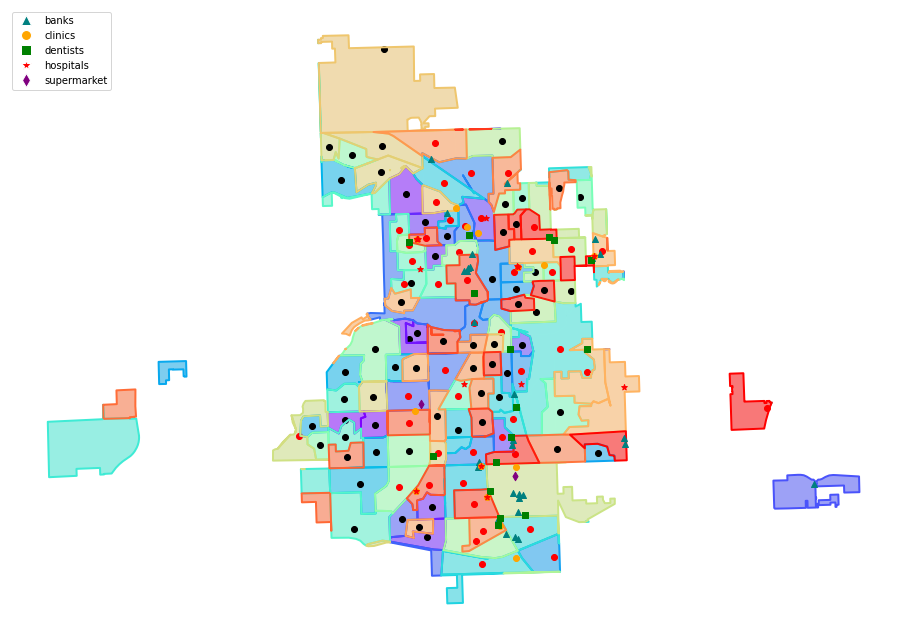

In [27]:
# census centroid

ax = city.plot(color="black", alpha=0.05, figsize=(16, 16), zorder=1)

new_census = census_gdf.to_crs(epsg).intersection(city.unary_union)
new_census[~new_census.is_empty].plot(ax=ax, cmap='rainbow', alpha=0.5)
new_census[~new_census.is_empty].boundary.plot(ax=ax, cmap='rainbow', linewidth=2)

points_low.to_crs(epsg).centroid.intersection(city.unary_union).plot(ax=ax, color='black')
points_high.to_crs(epsg).centroid.intersection(city.unary_union).plot(ax=ax, color='red')

banks.intersection(city.unary_union).plot(ax=ax, color='teal', marker='^', zorder=4)
clinics.intersection(city.unary_union).plot(ax=ax, color='orange', marker='o', zorder=4)
dentists.intersection(city.unary_union).plot(ax=ax, color='green', marker='s', zorder=4)
hospitals.intersection(city.unary_union).plot(ax=ax, color='red', marker='*', zorder=4)
supermarket.intersection(city.unary_union).plot(ax=ax, color='purple', marker='d', zorder=4)

ax.legend(handles = lineslist, loc="upper left",prop={"size": 10})
# ax.legend(handles = lineslist, bbox_to_anchor=(1.00, 1.00), loc="upper left",prop={"size": 10})

ax.set_axis_off()

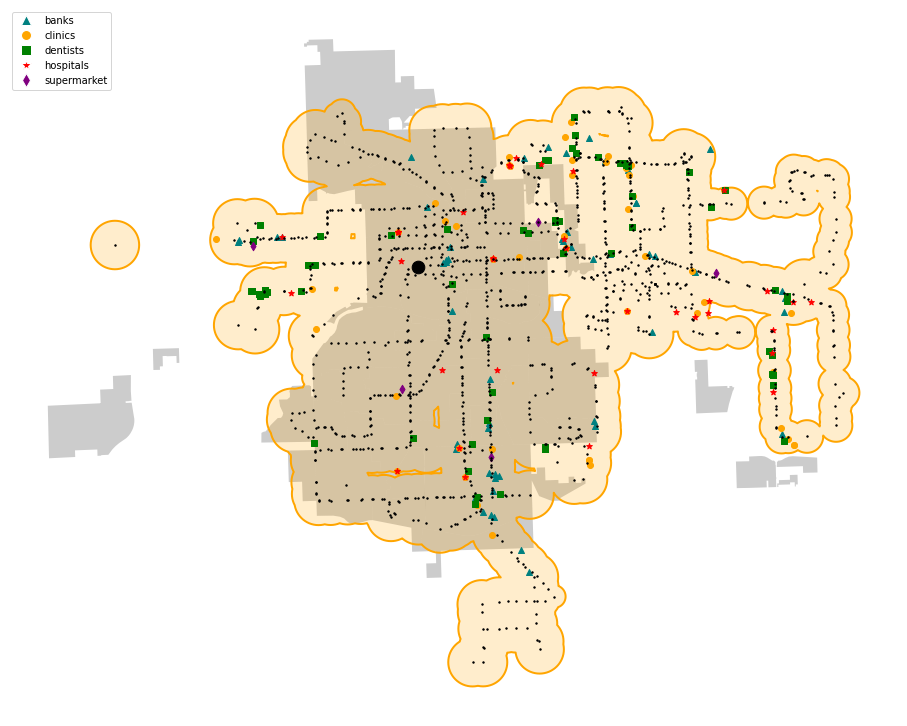

In [28]:
city = city.to_crs(epsg)
ax = city.plot(color="black", alpha=0.2, zorder=1, figsize=(16, 16))

colors = ["orange", "blue", "green", "yellow"]

zorder = 4
addr = '702 W Kalamazoo St, Lansing, MI'

location = geocode(addr)
lat, lon = (location.latitude, location.longitude)

gdf = busSim.get_gdf(start_point=(lat, lon)) # bubble
gdf = gdf.to_crs(epsg=epsg)

color = colors[0]
# bubble = flatten(gdf.difference(lakes.unary_union)) # the difference between bubble and lakes = bubble - lakes
bubble = gpd.GeoDataFrame(geometry= gpd.GeoSeries(gdf.unary_union), crs=epsg)
bubble["color"] = color
bubble.boundary.plot(color=color, ax=ax, linewidth=2, zorder=zorder+2)
# Round-trip the data through a flat projection, ideally one which preserves area, such as Equal Area Cylindrical ('+proj=cea')
gdf["geometry"].centroid.plot(color="black", ax=ax, markersize=2, zorder=zorder+4)
start = gpd.GeoSeries([Point(lon, lat)], crs=4326)
start = start.to_crs(epsg)
start.plot(ax = ax, marker='o', color="black", markersize=160, zorder=100) # draw start point

df = bubble
df.plot(alpha=0.2, ax=ax, color=df["color"], zorder=zorder) # plot bubble

bubble = bubble.loc[0, 'geometry']
banks_limit = banks.intersection(bubble)
banks_limit = gpd.GeoSeries(banks_limit, crs=epsg)
banks_limit.plot(ax=ax, color='teal', marker='^', zorder=zorder+3)

clinics_limit = clinics.intersection(bubble)
clinics_limit = gpd.GeoSeries(clinics_limit, crs=epsg)
clinics_limit.plot(ax=ax, color='orange', marker='o', zorder=zorder+3)

dentists_limit = dentists.intersection(bubble)
dentists_limit = gpd.GeoSeries(dentists_limit, crs=epsg)
dentists_limit.plot(ax=ax, color='green', marker='s', zorder=zorder+3)

hospitals_limit = hospitals.intersection(bubble)
hospitals_limit = gpd.GeoSeries(hospitals_limit, crs=epsg)
hospitals_limit.plot(ax=ax, color='red', marker='*', zorder=zorder+3)

supermarket_limit = supermarket.intersection(bubble)
supermarket_limit = gpd.GeoSeries(supermarket_limit, crs=epsg)
supermarket_limit.plot(ax=ax, color='purple', marker='d', zorder=zorder+3)

ax.legend(handles = lineslist, loc="upper left",prop={"size": 10})
# ax.legend(handles = lineslist, bbox_to_anchor=(1.00, 1.00), loc="upper left",prop={"size": 10})
# leg = ax.legend(leg_lines, leg_text, prop={"size": 18}, loc="upper left")
# leg.get_frame().set_facecolor("white")
# leg.get_frame().set_edgecolor("white")

ax.set_axis_off() # set axis off